In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [4]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [5]:
path = Path('/data/Datasets/EIPH_WSI/Patches/')

In [6]:
def get_float_labels(x: Path):
    return float(x.parent.stem)

In [7]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=90,  
                      #max_lighting=0.15, 
                      #max_zoom=2, 
                      #max_warp=0.2,
                      #p_affine=0.75,
                      #p_lighting=0.75,  
                      #xtra_tfms=xtra_tfms,
                     )

In [64]:
data = (ImageItemList.from_folder(path)
 .random_split_by_pct()
 .label_from_func(get_float_labels, label_cls=FloatList)
 .transform(tfms, size=128)
 .databunch(bs=64)) 
data.normalize()

ImageDataBunch;

Train: LabelList
y: FloatList (62434 items)
[FloatItem 2.0, FloatItem 2.0, FloatItem 2.0, FloatItem 2.0, FloatItem 2.0]...
Path: /data/Datasets/EIPH_WSI/Patches
x: ImageItemList (62434 items)
[Image (3, 82, 82), Image (3, 210, 210), Image (3, 106, 106), Image (3, 106, 106), Image (3, 118, 118)]...
Path: /data/Datasets/EIPH_WSI/Patches;

Valid: LabelList
y: FloatList (15608 items)
[FloatItem 0.0, FloatItem 1.0, FloatItem 1.0, FloatItem 0.0, FloatItem 1.0]...
Path: /data/Datasets/EIPH_WSI/Patches
x: ImageItemList (15608 items)
[Image (3, 90, 90), Image (3, 110, 110), Image (3, 108, 108), Image (3, 144, 144), Image (3, 112, 112)]...
Path: /data/Datasets/EIPH_WSI/Patches;

Test: None

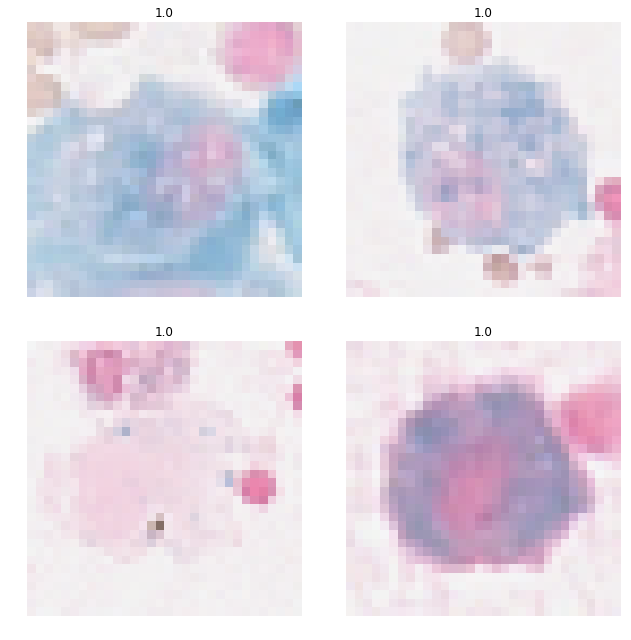

In [17]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

In [19]:
class L1LossFlat(nn.L1Loss):
    #Mean Absolute Error Loss
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [55]:
def create_regression_head(nf:int, nc:int, y_range=[-0.5,4.5],
                           lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [60]:
head = create_regression_head(1024, 1)

In [61]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=1, bias=True)
  (9): SigmoidRange()
)

In [65]:
learn = create_cnn(data, models.resnet18, callback_fns=[ShowGraph], custom_head=head)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


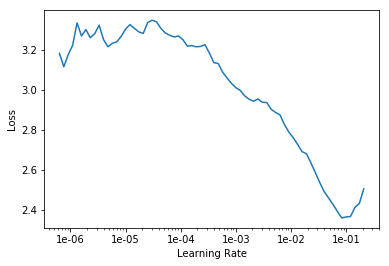

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss
1,0.202622,0.139407
2,0.150701,0.123348
3,0.148680,0.098793
4,0.122701,0.097884
5,0.121827,0.095763


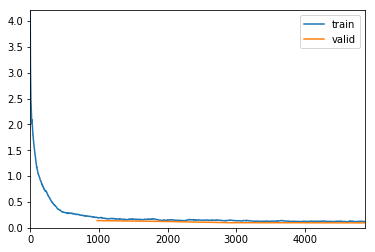

In [66]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

In [67]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss
1,0.117734,0.095901
2,0.122784,0.097351
3,0.118030,0.092920
4,0.116040,0.089907
5,0.107917,0.091381
6,0.102210,0.090061
7,0.100590,0.088076
8,0.100735,0.087494
9,0.100970,0.087724
10,0.097157,0.087522


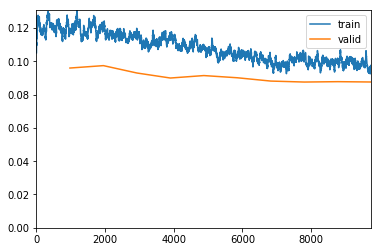

In [68]:
lr = 0.001
learn.fit_one_cycle(10, slice(1e-5, lr/5))

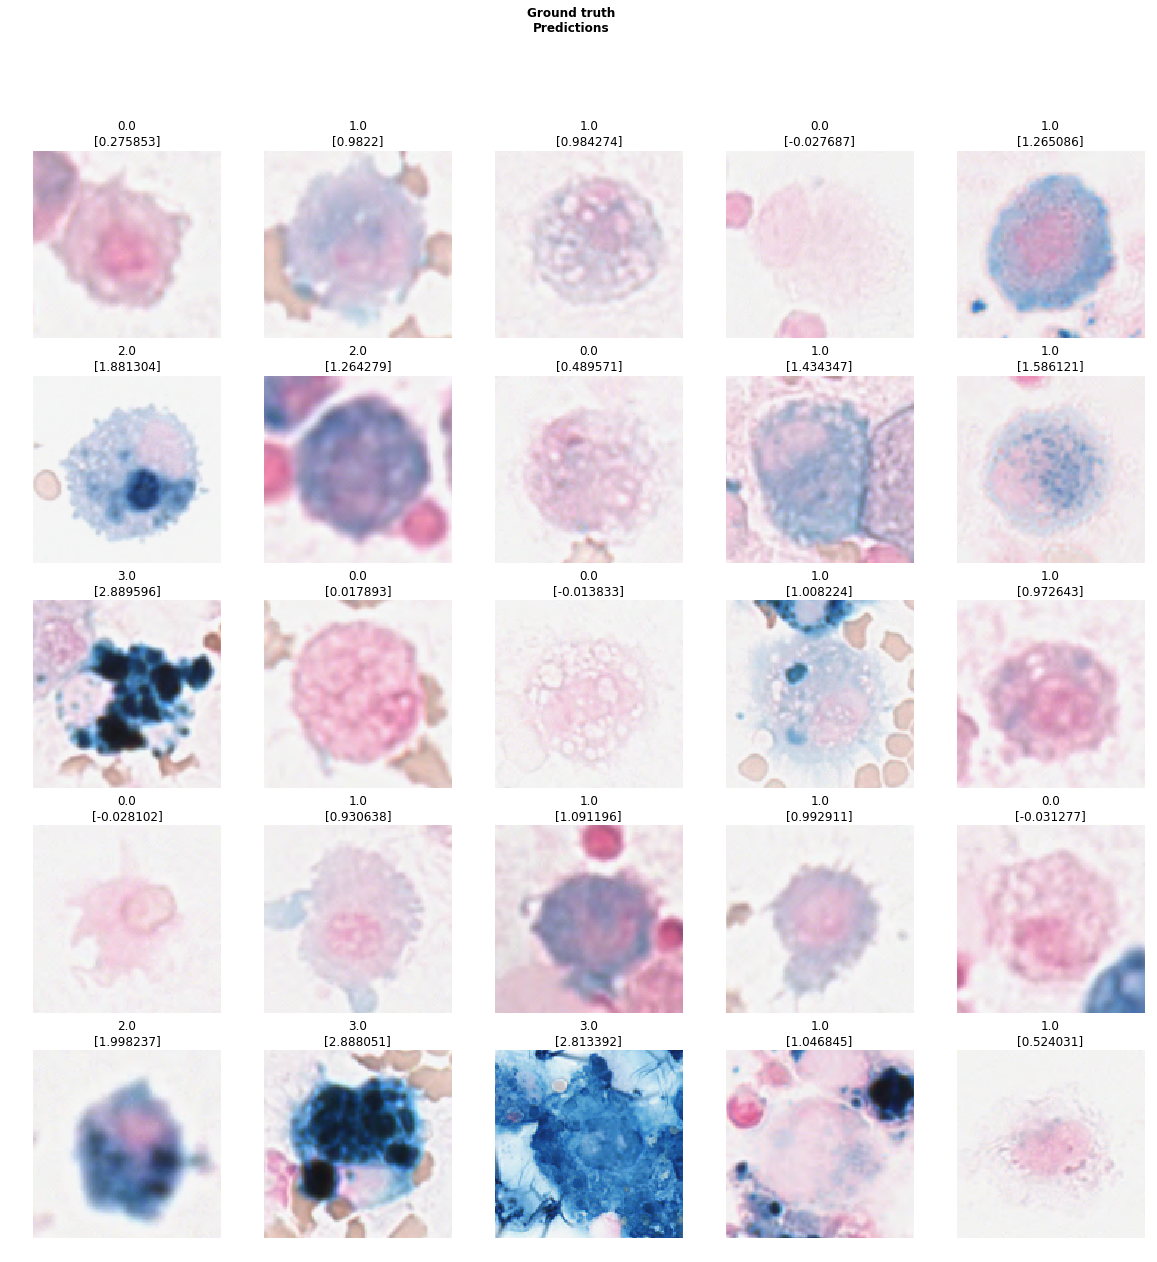

In [69]:
learn.show_results()

In [70]:
y_pred, y_true = learn.get_preds(ds_type=DatasetType.Valid)

In [71]:
y_pred = to_np(y_pred).flatten()
y_true = to_np(y_true).astype(np.uint)

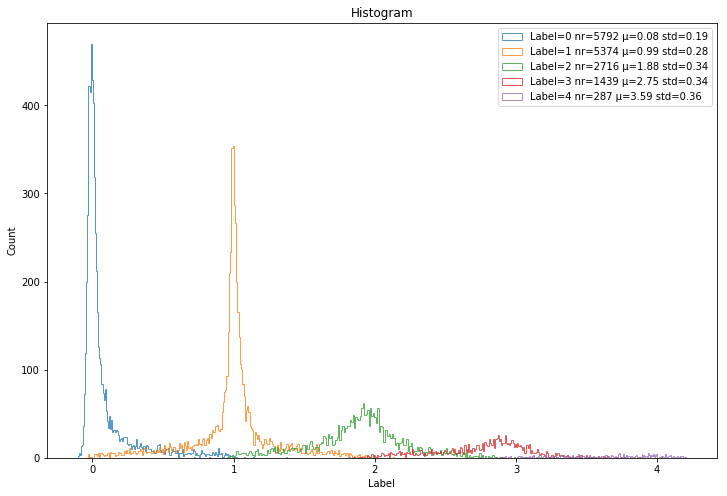

In [124]:
plt.figure(figsize=(12, 8))

for i in set(y_true): 
    y_pred_temp = y_pred[np.where(y_true == i)]
    mean = np.mean(y_pred_temp)
    std = np.std(y_pred_temp)
    n, bins, patches = plt.hist(y_pred_temp, 
                                250, 
                                #normed=1, 
                                alpha=0.75, 
                                histtype='step', label="Label={} nr={} µ={:1.2f} std={:1.2f}".format(i, len(y_pred_temp),  mean, std),
                               #log =True
                               )


plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram')


plt.legend(loc='best');
plt.show()